# Test annotated data

In [1]:
import json
annotated_data = json.load(open('../data/val.json'))

In [2]:
print(json.dumps(annotated_data[:10], ))

[{"video_id": "cfBtVPEwqIo", "video_start_time": 5, "video_end_time": 15, "caption": "In a gym with someone spotting him, a man is lifting weights performing squats in a squat rack.", "masked_caption": "In a gym with someone spotting him, a man is lifting _____ performing squats in a squat rack.", "label": "weights", "additional_answers": [["a weight", "some weights", "a squat bar"], ["weight", "a bar"], ["weights", "a heavy load"], ["weights", "a lot of weight"], ["weights", "a barbell", "a weight"], ["weights", "405 lb"]]}, {"video_id": "P7CgvqGhidw", "video_start_time": 73, "video_end_time": 83, "caption": "A couple of people on stage playing music while in front of other people.", "masked_caption": "A couple of people on stage playing music while in _____ of other people.", "label": "front", "additional_answers": [["close proximity", "close comfort"], ["front", "a room full"], ["front", "view"], ["entretaining", "talking"], ["front", "the way"], ["concert", "room"]]}, {"video_id": 

## Noun distribution
Let's look at the top-K nouns for (1) ground-truth data and (2) labeled data.

In [3]:
import pandas as pd
ground_truth_labels = list(map(lambda x: x['label'].lower(), annotated_data))
ground_truth_label_counts = pd.Series(ground_truth_labels).value_counts()
display(ground_truth_label_counts.head(20))

a man          46
a person       27
it             23
a woman        21
people         13
them           12
someone        10
he             10
a group        10
front          10
a young man     8
a boy           8
a piece         7
a child         6
a girl          6
two boys        5
they            5
the water       5
a lady          4
a baby          4
dtype: int64

In [4]:
from functools import reduce
annotation_labels = []
for annotated_data_i in annotated_data:
    for annotations_j in annotated_data_i['additional_answers']:
        clean_annotations_j = list(map(lambda x: x.lower(), annotations_j))
        annotation_labels.extend(clean_annotations_j)
annotation_label_counts = pd.Series(annotation_labels).value_counts()
display(annotation_label_counts.head(20))

a person    392
a man       381
a woman     181
a guy       164
people      154
someone     133
a girl      115
a boy       111
a group     108
a child     104
a kid       103
a lady       93
man          70
it           68
kids         68
music        61
a baby       59
the man      57
he           54
boys         50
dtype: int64

### Nouns with low/high agreement
Which nouns have lower or higher agreement?

We'll measure agreement with exact overlap to start, and then partial overlap if we need more data.

In [13]:
def get_exact_overlap(data):
    label = data['label'].lower()
    annotations = [y.lower() for x in data['additional_answers'] for y in x] # all annotations
#     annotations = [y.lower() for x in data['additional_answers'] for y in x[:1]] # restrict to first annotations only
    exact_matches = list(filter(lambda x: x==label, annotations))
    exact_overlap_score = len(exact_matches) / len(annotations)
    return exact_overlap_score

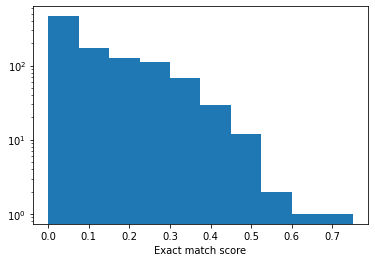

In [14]:
# show distribution first
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
valid_annotated_data = list(filter(lambda x: len(x['additional_answers']) > 0, annotated_data))
exact_overlap_scores = list(map(lambda x: get_exact_overlap(x), valid_annotated_data))
plt.hist(exact_overlap_scores)
plt.xlabel("Exact match score")
plt.yscale('log')
plt.show()

Most questions have fairly low rate of exact matches, which may be unusually low for questions with higher number of annotations provided.

In [15]:
## compute average overlap per NP
valid_annotated_data_labels = list(map(lambda x: x['label'], valid_annotated_data))
label_annotation_overlap = pd.DataFrame(list(zip(valid_annotated_data_labels, exact_overlap_scores)), columns=['label', 'overlap_score'])
label_annotation_overlap_aggregate = label_annotation_overlap.groupby('label').apply(lambda x: x.loc[:, 'overlap_score'].mean())
label_annotation_overlap_aggregate.sort_values(inplace=True, ascending=False)
print('ground-truth labels with highest annotation overlap')
display(label_annotation_overlap_aggregate.head(20))
label_annotation_overlap_aggregate.sort_values(inplace=True, ascending=True)
print('ground-truth labels with lowest annotation overlap')
display(label_annotation_overlap_aggregate.head(20))

ground-truth labels with highest annotation overlap


label
step              0.750000
top               0.600000
camera            0.555556
eggs              0.500000
you               0.500000
drinks            0.466667
the air           0.455882
she               0.447917
air drums         0.444444
turns             0.444444
the end           0.411765
himself           0.411376
a horse           0.388889
a pillow fight    0.384615
who               0.380952
the wall          0.375000
their hands       0.375000
a hose            0.375000
his shirt         0.363636
a long jump       0.357143
dtype: float64

ground-truth labels with lowest annotation overlap


label
your dashboard stereo             0.0
a file                            0.0
a fake bull                       0.0
a facial brush                    0.0
a double backflip                 0.0
a dock                            0.0
a dark room                       0.0
a dance performance               0.0
a couple kids                     0.0
a concrete driveway               0.0
a complex stretching yoga pose    0.0
a competitive wrestling match     0.0
a comment                         0.0
a city street                     0.0
a buffering machine               0.0
a bow tie collar                  0.0
a flute like instrument           0.0
a bouncy swing                    0.0
a footfall                        0.0
his panning plate                 0.0
dtype: float64

The words with higher agreement tend to be simple and concrete nouns (`step`, `camera`), as well as situation-specific (?) pronouns (`she`, `himself`).

The words with lower agreement tend to be highly specific (`your dashboard stereo`, `a flute like instrument`) or vague (`comment`, `city street`).

## Tokens per NP
How many tokens on average does each noun phrase contain?

We'll look at this for both ground-truth and annotations.

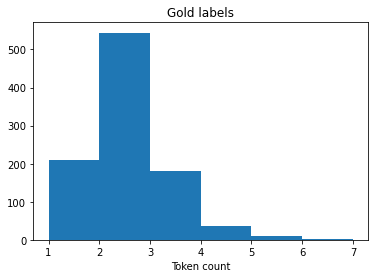

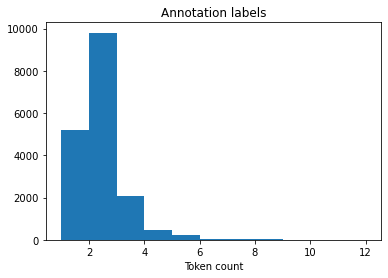

gold label NPs have 2.091 +/- 0.834 tokens
annotation NPs have 1.943 +/- 0.879 tokens


In [39]:
from nltk.tokenize import WordPunctTokenizer
import numpy as np
tokenizer = WordPunctTokenizer()
label_token_counts = list(map(lambda x: len(tokenizer.tokenize(x)), valid_annotated_data_labels))
flat_annotation_labels = [z for x in valid_annotated_data for y in x['additional_answers'] for z in y]
annotation_label_token_counts = [len(tokenizer.tokenize(x)) for x in flat_annotation_labels]
## show both distributions
plt.hist(label_token_counts, bins=max(label_token_counts)-1)
plt.xlabel('Token count')
plt.title('Gold labels')
plt.show()
plt.hist(annotation_label_token_counts, bins=max(annotation_label_token_counts)-1)
plt.xlabel('Token count')
plt.title('Annotation labels')
plt.show()
print('gold label NPs have %.3f +/- %.3f tokens'%(np.mean(label_token_counts), np.std(label_token_counts)))
print('annotation NPs have %.3f +/- %.3f tokens'%(np.mean(annotation_label_token_counts), np.std(annotation_label_token_counts)))
## failed attempt to plot overlap (small bars)
# import seaborn as sns
# combined_token_counts = pd.DataFrame([
#     label_token_counts + annotation_label_token_counts,
#     ['gold',]*len(label_token_counts) + ['annotation',]*len(annotation_label_token_counts)
# ], index=['token_count', 'label_type']).transpose()
# sns.histplot(data=combined_token_counts, x='token_count', 
#              hue='label_type', stat='probability', common_norm=False,
#              multiple='dodge')
# plt.show()

The gold labels tend to be slightly longer, and annotation labels are more central-skewed (2 words or below) vs. the long tail of tokens in the gold labels.

What are the longest/shortest labels in each set?

In [48]:
label_token_count_data = pd.Series(label_token_counts, index=list(map(lambda x: x.lower(), valid_annotated_data_labels))).sort_values(inplace=False, ascending=False)
flat_annotation_label_token_count_data = pd.Series(annotation_label_token_counts, index=list(map(lambda x: x.lower(), flat_annotation_labels))).sort_values(inplace=False, ascending=False)
label_token_count_data = label_token_count_data[~label_token_count_data.index.duplicated()]
flat_annotation_label_token_count_data = flat_annotation_label_token_count_data[~flat_annotation_label_token_count_data.index.duplicated()]
print('longest gold label NPs')
display(label_token_count_data.head(20))
print('longest annotation NPs')
display(flat_annotation_label_token_count_data.head(20))

longest gold label NPs


her over-stressed tank-top          7
an innocent cute little baby boy    6
the black and white knitting kit    6
her ice-skating skills              5
an ornately costumed dance squad    5
a man's back                        5
each other's heads                  5
a large multiple dig site           5
three-wheeled recumbent bikes       5
a person's hands                    5
a very well built woman             5
a basic photo copy machine          5
a complex stretching yoga pose      5
a women's leg                       5
hand-held weights                   4
a yellow reflective vest            4
a small robotic vehicle             4
a very small do                     4
a blow up toy                       4
a red hot piece                     4
dtype: int64

longest annotation NPs


a boy in black and a boy in blue t-shirt                12
the poor animal who needs it's wool to stay warm        12
2 teams, one in yellow jerseys and one white jerseys    11
a girl in t-shirt and bathing suit bottom               10
a cowboy wearing blue jeans and blue jean jacket         9
a man in shorts and black t-shirt                        9
a male wearing shoes and black pants with stripes        9
a t-shirt with a pyramid on it                           9
a kid in pants and t-shirt                               8
a girl in t-shirt and jeans                              8
2 males wearing a blue shirt and shorts                  8
a man in shorts and t-shirt                              8
man in a white shirt and black pants                     8
a kid in black shirt and black pants                     8
the street in front of the house driveway                8
a man wearing glasses and a hat,                         8
a grass area next to a parking lot                      

The longest NPs for the gold labels tend to have multiple adjectives (`an innocent cute little baby boy`) and possessive markers (`a man's back`).

The longest NPs for the annotation labels tend to have coordination (`a man in shorts and black t-shirt`) and long, unnecessary subclauses (`the poor animal who needs it's wool to stay warm`).

### Unique NPs per question
How many unique NPs does each question get?

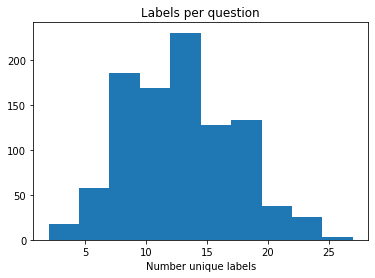

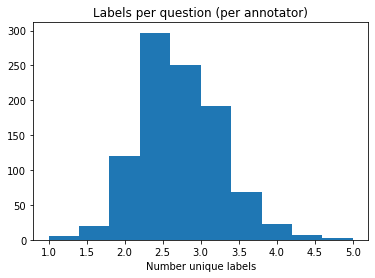

questions have an average of 12.563 +/- 4.393 unique labels
annotators have an average of 2.704 +/- 0.534 unique labels


In [66]:
def get_num_unique_labels_per_annotator(data):
    ## TODO: only include first label from each annotator? some annotators may have included extra words just for bonus
    data_annotation_label_sets = [set([y.lower() for y in x]) for x in data['additional_answers']]
    num_unique_data_annotation_labels = list(map(lambda x: len(x), data_annotation_label_sets))
    mean_unique_data_annotation_labels = np.mean(num_unique_data_annotation_labels)
    return mean_unique_data_annotation_labels
unique_labels_per_question = list(map(lambda x: list(sorted(set([z.lower() for y in x['additional_answers'] for z in y]))), valid_annotated_data))
num_unique_labels_per_question = list(map(lambda x: len(x), unique_labels_per_question))
num_unique_labels_per_question_per_annotator = list(map(lambda x: get_num_unique_labels_per_annotator(x), valid_annotated_data))
plt.hist(num_unique_labels_per_question){}
plt.xlabel('Number unique labels')
plt.title('Labels per question')
plt.show()
plt.hist(num_unique_labels_per_question_per_annotator)
plt.xlabel('Number unique labels')
plt.title('Labels per question (per annotator)')
plt.show()
print('questions have an average of %.3f +/- %.3f unique labels'%(np.mean(num_unique_labels_per_question), np.std(num_unique_labels_per_question)))
print('annotators have an average of %.3f +/- %.3f unique labels'%(np.mean(num_unique_labels_per_question_per_annotator), np.std(num_unique_labels_per_question_per_annotator)))

Most questions have around 12 unique labels total and 3 unique labels per annotator.

Which questions have the most unique labels per annotator?

In [67]:
pd.set_option('display.max_colwidth', 200)
question_prompts = list(map(lambda x: x['masked_caption'], valid_annotated_data))

unique_labels_per_question_per_annotator_data = pd.DataFrame([
    question_prompts,
    unique_labels_per_question_per_annotator,
    unique_labels_per_question,
], index=['prompt', 'unique_label_count', 'unique_labels']).transpose()
unique_labels_per_question_per_annotator_data.sort_values('unique_label_count', inplace=True, ascending=False)
print('questions with highest number unique labels per annotator')
display(unique_labels_per_question_per_annotator_data.head(10))
print('questions with lowest number unique labels per annotator')
display(unique_labels_per_question_per_annotator_data.tail(10))

questions with highest number unique labels per annotator


,prompt,unique_label_count,unique_labels
278,_____ lifts a heavy weight from the ground up.,5.0,"[a body builder, a bodybuilder, a female, a female athlete, a female body builder, a female bodybuilder, a gal, a girl, a lady, a small lady, a small woman, a tiny lady, a weight lifter, a woman, ..."
905,A group of drivers race cars on _____ in front of onlookers.,4.8,"[a circuit, a course, a dirt track, a field, a racetrack, a raceway, a speedway, a stretch, a track, clay, dirt, dirt path, dry sand, mud, race grounds, sand, the dirt, the ground, the mud, the tr..."
260,A man is walking by _____ that is completely full then comes back and smashes the computer monitor sitting on top with a baseball bat.,4.714286,"[a bin, a black bin, a black bin with garbage, a black garbage bin, a black rubbish bin, a black trash can, a black trashcan, a dumpster, a garbage bin, a garbage can, a garbage receptacle, a grey..."
427,A group of _____ in pink tutus dancing in a circle on stage.,4.428571,"[arm-in-arm girls, balet students, ballerinas, children, dancers, girls, kids, little girls, little kids, students, toddlers, young ballerinas, young dancers, young girls]"
45,A woman works with _____ at a spinning potter's wheel.,4.428571,"[a bowl, a class, a piece of pottery, boys, boys and girls, clay, ease, focus, girls, her children, her class, her family, her hands, her kids, her students, kids, lady, mud, potter, pottery, skil..."
831,_____ uses several smaller containers to efficiently pack a suitcase while music plays.,4.333333,"[a chick, a girl, a lady, a lass, a person, a traveler, a woman, female, person, someone, woman, young lady]"
835,_____ was picking berries from a bush outside on a sunny day.,4.333333,"[a family, a mother and daughter, a person, a woman, a woman and a girl, a young lady and an old lady, adult and child, duo, folks, girl, mother and daughter, people, woman]"
936,_____ kicks soccer balls into a net while on a grass field.,4.333333,"[a boy, a child, a guy, a human, a kid, a male, a person, a player, a soccer player, a son, a team member, a young boy, a youth, an adolescent, athlete, boy, my daughter's friend, our neighbor, pl..."
576,_____ plays an instrument while wearing a pink shirt.,4.2,"[a bald man, a guy, a man, a musician, a performer, a person, a saxophone player, a saxophonist, a singer, an entertainer, an individual, an old man, an older man, artist, musician, someone]"
749,A man standing in front of a microphone playing some kind of _____.,4.2,"[an harmonica-like instrument, flute, instrument, music, musical instrument, noise, pan flute, pan flute music, panflute, pipe, song, tool, unknown instrument, wood instrument, wooden instrument, ..."


questions with lowest number unique labels per annotator


,prompt,unique_label_count,unique_labels
645,A man demonstrates how to install _____.,1.666667,"[a bicycle chain, a bike chain, a cycle chain, a master link, a new bike chain, a piece of equipement, new chain links, the chain]"
863,The man in _____ checks and trims the toenails of a small animal.,1.625,"[a black sweater, a knit shirt, a sweater, a warm sweater, black pants, chair, the clip, the vet's office, the video]"
613,Two person one standing on _____ and the other doing a cock wheel.,1.6,"[his head, the circle, the floor, the groung, their head, top of his head]"
468,A man juggles balls one-handed and then two-handed and tosses them to a person off-_____.,1.5,"[balance, camera, frame, shot, the shot]"
306,A toddler boy is feeding _____ spaghetti at the dinner table.,1.5,"[forkfuls of, himself, his belly, his mouth, while sitting and using fork to eat]"
720,A young boy who seems to be timing _____ how fast he can eat a snack.,1.333333,"[a challenge of, a recording of, himself, his self, to calculate, to see]"
747,"A man, outdoors at a gas station, is demonstrating step-by-_____, how to pump gas.",1.333333,"[step, the way]"
214,"Two teams play football, and the team in _____ completes a pass.",1.333333,"[offense, red jerseys, red shirts, the left]"
705,Packages of paper are being wrapped in paper plastic and stacked on _____ of each other.,1.25,"[a device next, a machine, top]"
847,A person is showing how _____ open a beer with a screw driver indoors.,1.0,"[he, people, to screw open, you]"


Questions with higher number of unique labels seem to inspire creative answers (`a group of ____ in pink tutus` => different paraphrases for `child`) and address multiple possible aspects of an event due to ambiguity (`a woman works with ____` => "with" applies to other `AGENT` nouns and `INSTRUMENT` nouns).

Questions with lower number of unique labels seem to have very specific scenarios without room for paraphrasing or ambiguity (`to a person off-____` => the blank can only be "camera").